In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import glob
import warnings

warnings.filterwarnings('ignore')

sns.set(rc={"figure.dpi":1200})
sns.set_context('notebook')
sns.set_style("ticks")

mpl.style.use('default')

# Update rcParams for global consistency
mpl.rcParams.update({
    'axes.linewidth': 7,           # Line width for axes
    'xtick.major.size': 20,        # Major tick size
    'xtick.major.width': 7,        # Major tick width
    'xtick.minor.size': 10,        # Minor tick size
    'xtick.minor.width': 7,        # Minor tick width
    'ytick.major.size': 20,        # Major tick size
    'ytick.major.width': 7,        # Major tick width
    'ytick.minor.size': 10,        # Minor tick size
    'ytick.minor.width': 7,        # Minor tick width
    'ytick.labelsize': 48,         # Label size for y ticks
    'xtick.labelsize': 48,         # Label size for x ticks
    'font.size': 60,               # Font size for text
    'font.sans-serif': 'Arial',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Arial',
    'mathtext.it': 'Arial',
    'mathtext.bf': 'Arial:bold',
    'lines.linewidth': 7,          # Line width for all lines
    'scatter.marker': 'o',         # Default marker for scatter
    'lines.markersize': 10,        # Marker size for scatter in points
    'axes.titlesize': 'large',     # Title size
    'axes.labelsize': 'large',     # Label size for axes
    'legend.fontsize': 'large'     # Font size for legends
})


In [3]:
df = pd.read_csv('HIF1A_CITED2_SIGNIFICANT_ACTIVITY_STALLER.csv')
df = df[df['-log10_p-values'] > 1.30102999566]
df = df[(df['log2_FC'] > 1) | (df['log2_FC'] < -1)]
####REMOVE ANY SEQUENCE THAT DOESN'T HAVE A STANDARD AMINO ACID
# Assuming df is your DataFrame and it already exists with a column 'ADseq' containing the sequences
standard_aa = set('ACDEFGHIKLMNPQRSTVWY')  # Set of standard amino acid characters

# Use DataFrame.apply to check each sequence, keeping only those that are subsets of standard_aa
df = df[df['ADseq'].apply(lambda x: set(x.upper()).issubset(standard_aa))]

# Now 'df' will include a 'status' column with the categories 'activating', 'deactivating', or 'neutral'
# Assuming 'df' is your DataFrame and 'log2_FC' is your column of interest
df['status'] = df['log2_FC'].apply(lambda x: 'deactivating' if x < -1 else ('activating' if x > 1 else 'neutral'))

In [4]:
import pandas as pd
from sparrow import Protein
# from sparrow import AnalyticalFRC

# Initialize an empty DataFrame for storing results
results_df = pd.DataFrame()

# Iterate over each sequence in the 'ADseq' column of df
for idx, IDR_seq in df['ADseq'].items():  # Use .items() for Series
    # Initialize a dictionary to hold the data for this sequence
    IDR_data = {'ADseq': IDR_seq}  # Add the sequence itself to IDR_data
    
    # Predict properties using Sparrow
    P = Protein(IDR_seq)
    IDR_data['Rg'] = P.predictor.radius_of_gyration()
    IDR_data['Re'] = P.predictor.end_to_end_distance(use_scaled=True)
    IDR_data['Asphericity'] = P.predictor.asphericity()
    
    # Get other properties of IDR
    IDR_data['NCPR'] = P.NCPR
    IDR_data['FCR'] = P.FCR
    IDR_data['kappa'] = P.kappa
    IDR_data['hy_KD'] = P.hydrophobicity
    IDR_data['hy_clust'] = P.compute_kappa_x(["I","L","V","A","M"])
    IDR_data['aro_clust'] = P.compute_kappa_x(["F","Y","T","W","L"])
    IDR_data['AEM clustering'] = P.compute_kappa_x(["F","Y","L",'W'],['D','E'])
    IDR_data['SCD'] = P.SCD
    IDR_data['SHD'] = P.SHD
    IDR_data['NCPR'] = P.complexity
    IDR_data['Aromatic Fraction'] = P.fraction_aromatic
    IDR_data['Negative Charge Fraction']= P.fraction_negative
    
# Calculate the fraction of specific amino acids
    specific_amino_acids = ['D', 'E', 'L', 'W', 'T', 'F', 'Y']

    IDR_data['AEM Fraction'] = P.compute_residue_fractions(specific_amino_acids)

    single_idr_df = pd.DataFrame([IDR_data])
    # Append this row to the results_df
    results_df = pd.concat([results_df, single_idr_df], ignore_index=True)

# At this point, results_df contains all the calculated data for each sequence in 'ADseq', including the sequence itself
results_df
# Assuming 'df' and 'results_df' are your DataFrames
# And 'ADseq' is the column you want to match on
combined_df = pd.merge(df, results_df, on='ADseq', how='left')
combined_df.rename(columns={'Re_normalized': r'$R_{e}$ Normalized'}, inplace=True)


Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


In [5]:
print(combined_df.columns)
filtered_df = combined_df[combined_df['Hif1alpha']]
# Assuming 'df' is your DataFrame
filtered_df.to_csv('filtered_df.csv', index=False)


Index(['Index', 'ADseq', 'Variant_Name', 'SystematicName',
       'Activity_Mean_MSS18', 'Activity_std_MSS18',
       'Biological_Replicate_1_Activity', 'Biological_Replicate_2_Activity',
       'Biological_Replicate_3_Activity', 'Biological_Replicate_4_Activity',
       '8_Bin_sort', 'WT', 'HandDesigned', 'PerturbCharge', 'PerturbAromatics',
       'CITED2', 'Stat3', 'Hif1alpha', 'p65_L2Y', 'p65', 'VP16 H1',
       'CorrectedPvalues_FDR_5percent', 'SigDiffFromWT', 'ree (nm)', 'length',
       'activity', '-log10_p-values', 'normalized_activity', 'log2_FC',
       '$R_{e}$ Normalized', 'status', 'Rg', 'Re', 'Asphericity', 'NCPR',
       'FCR', 'kappa', 'hy_KD', 'hy_clust', 'aro_clust', 'AEM clustering',
       'SCD', 'SHD', 'Aromatic Fraction', 'Negative Charge Fraction',
       'AEM Fraction'],
      dtype='object')


In [6]:
import pandas as pd
import scipy.stats as stats

# Load your DataFrame here if not already loaded
# filtered_df = pd.read_csv('your_data.csv')

# List of columns to perform t-tests on
features = ['$R_{e}$ Normalized', 'Rg', 'Re', 'Asphericity', 'NCPR', 'FCR', 'kappa',
            'hy_KD', 'hy_clust', 'aro_clust', 'AEM clustering', 'SCD', 'SHD', 'Aromatic Fraction', 'Negative Charge Fraction',
       'AEM Fraction']

# Initialize a dictionary to hold the t-test results
t_test_results = {}

def is_significant(p_val):
    if p_val < 0.0001:
        return '***'  # Triple asterisk for p < 0.0001
    elif p_val < 0.001:
        return '**'   # Double asterisk for p < 0.001
    elif p_val < 0.01:
        return '*'    # Single asterisk for p < 0.01
    else:
        return 'NS'  # No annotation for p >= 0.01

for feature in features:
    # Split the data into two groups based on the 'status' column
    group1 = filtered_df[filtered_df['status'] == 'activating'][feature]
    group2 = filtered_df[filtered_df['status'] == 'deactivating'][feature]
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Using Welch's t-test by default
    
    # Store the results including the asterisk annotation
    t_test_results[feature] = {'t-statistic': t_stat, 'p-value': p_value, 'asterisk': is_significant(p_value)}

# Convert results dictionary to DataFrame for nicer display
t_test_results_df = pd.DataFrame(t_test_results).transpose()

print(t_test_results_df)


                         t-statistic   p-value asterisk
$R_{e}$ Normalized          3.870655  0.001511        *
Rg                          3.638594  0.002638        *
Re                          3.870654  0.001511        *
Asphericity                 4.981517  0.000179       **
NCPR                       -0.718662  0.483433       NS
FCR                         1.551072  0.163197       NS
kappa                      -1.674856  0.137771       NS
hy_KD                       2.832522  0.014504       NS
hy_clust                   -0.880057  0.404463       NS
aro_clust                   1.165717  0.276803       NS
AEM clustering             -1.569437  0.137425       NS
SCD                         3.629434   0.00716        *
SHD                         1.155531  0.265962       NS
Aromatic Fraction          -1.731479  0.116063       NS
Negative Charge Fraction    3.680743  0.002432        *
AEM Fraction                2.141325  0.050049       NS


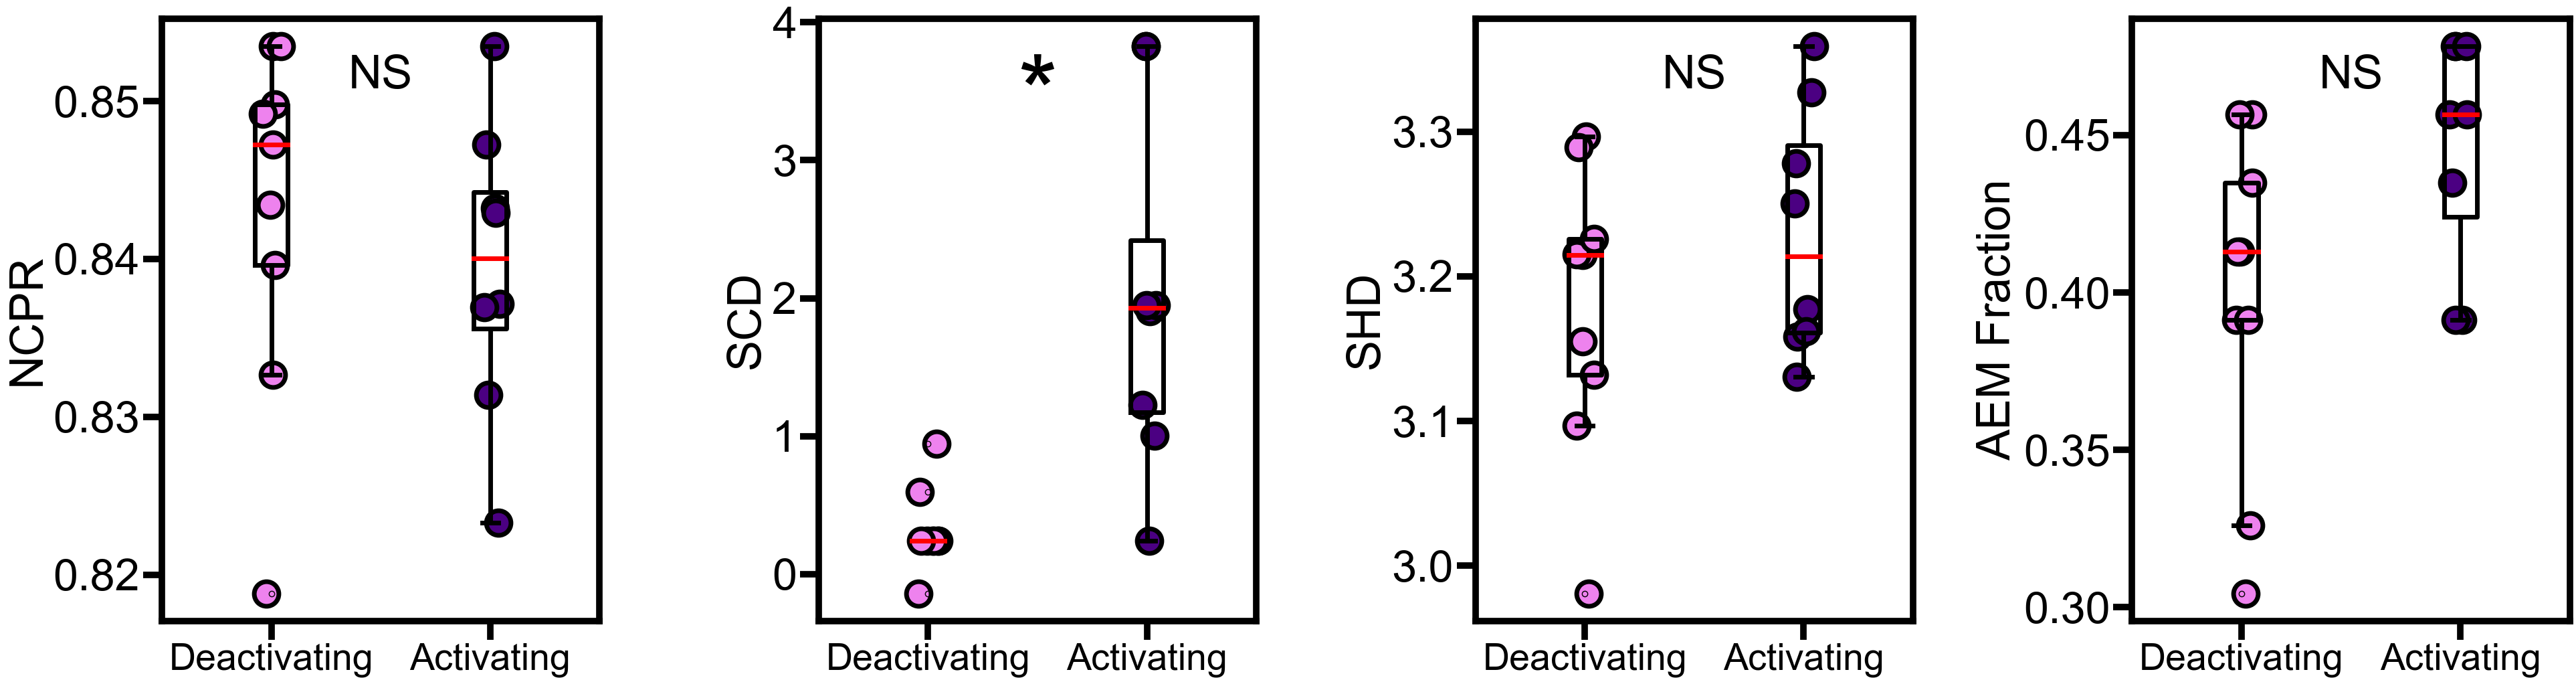

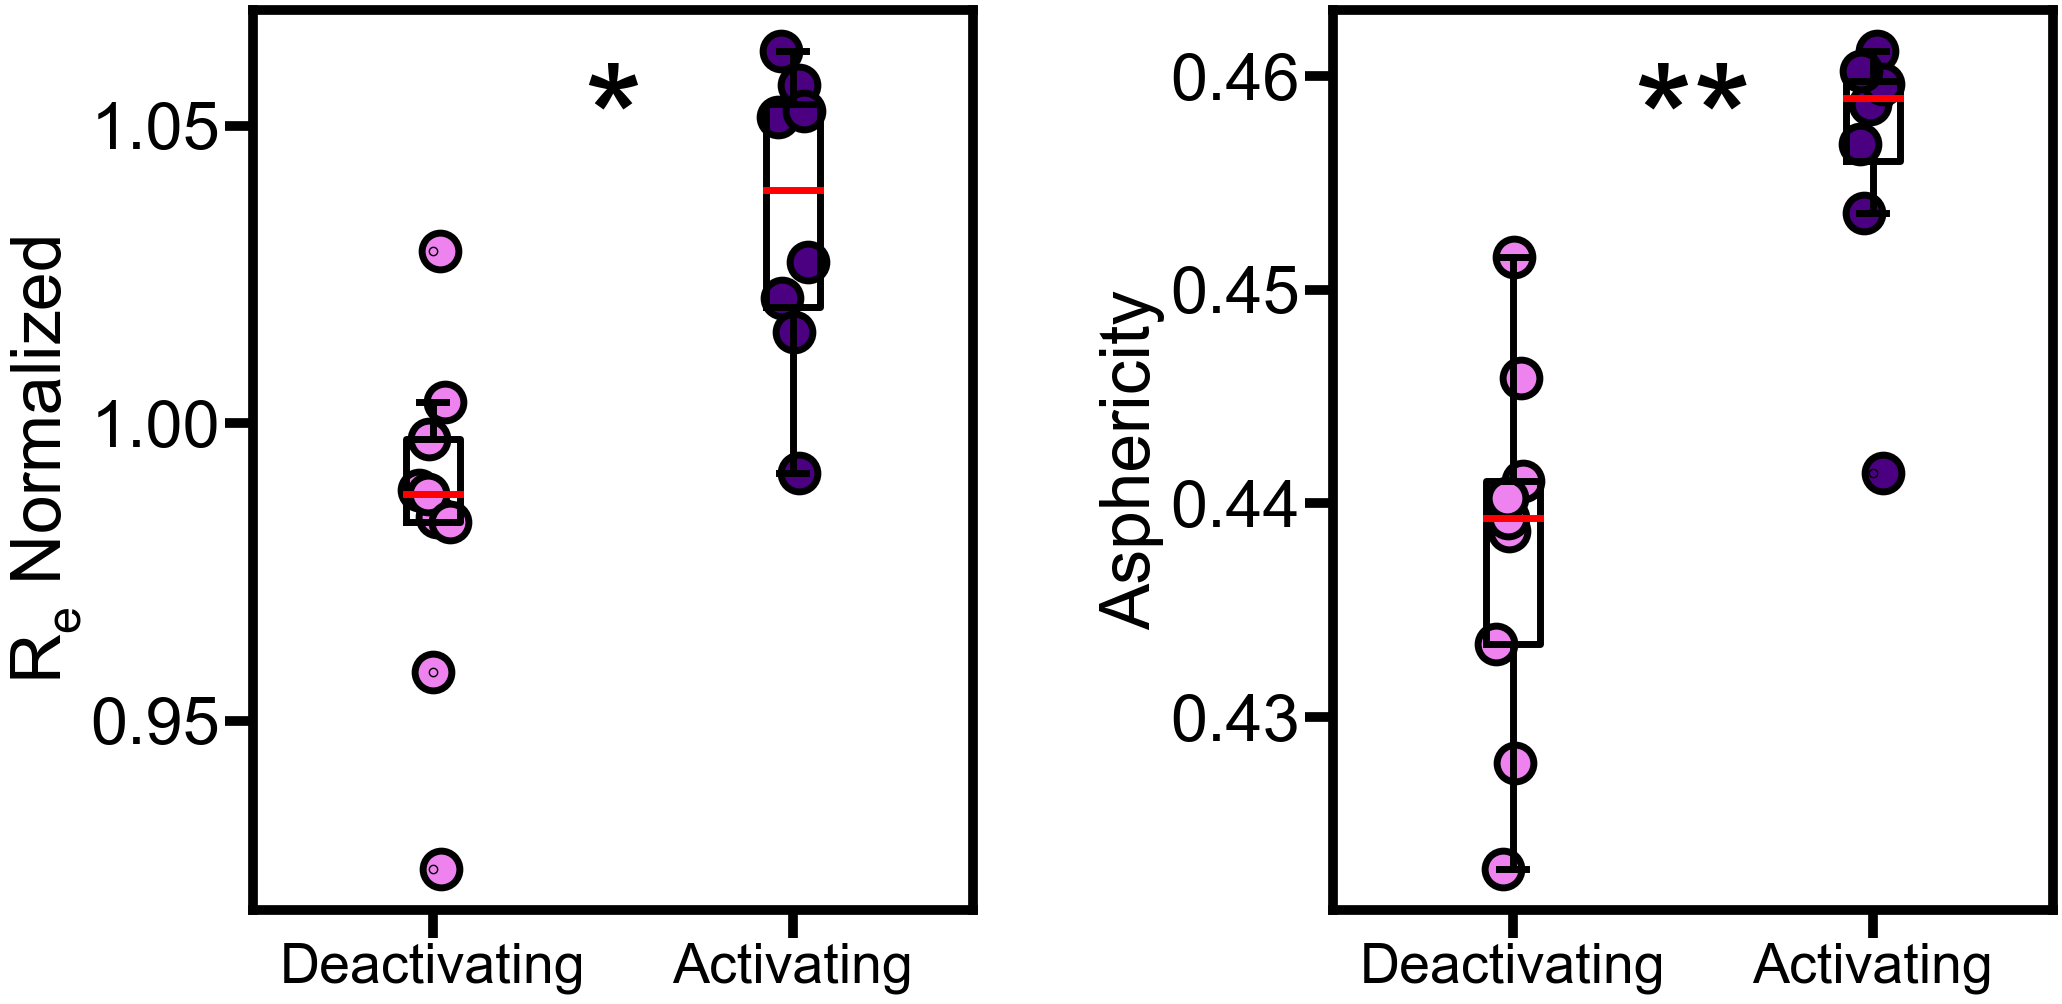

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# List of features to plot
features = ['NCPR', 'SCD', 'SHD', 'AEM Fraction', '$R_{e}$ Normalized', 'Asphericity']

# Create the first figure for the first row of subplots (first 4 features)
fig1, axs1 = plt.subplots(1, 4, figsize=(40, 10))

# Function to add jitter
def add_jitter(values, jitter_strength=0.1):
    return values + np.random.uniform(-jitter_strength, jitter_strength, size=len(values))

# Loop through the first 4 features and plot them in the first figure
for i, feature in enumerate(features[:4]):
    # Filter the DataFrame for rows where 'Hif1alpha' is True
    filtered_df = combined_df[combined_df['Hif1alpha']]

    # Get values for the current feature based on the 'status' condition
    deactivating_values = filtered_df[filtered_df['status'] == 'deactivating'][feature]
    activating_values = filtered_df[filtered_df['status'] == 'activating'][feature]

    # Create boxplots on the current axis
    ax = axs1[i]
    boxplots = ax.boxplot([deactivating_values, activating_values], patch_artist=False)

    # Setting the linewidth for the boxplot components
    for element in ['boxes', 'whiskers', 'caps']:
        plt.setp(boxplots[element], linewidth=5, color='black')

    # Set the median line color to red
    plt.setp(boxplots['medians'], linewidth=5, color='red')

    # Add scatter plot with jittered x positions for each category
    x_deactivating = add_jitter(np.ones(len(deactivating_values)), jitter_strength=0.05)
    x_activating = add_jitter(2 * np.ones(len(activating_values)), jitter_strength=0.05)
    ax.scatter(x_deactivating, deactivating_values, color='violet', s=700, edgecolor='black', linewidths=5)
    ax.scatter(x_activating, activating_values, color='indigo', s=700, edgecolor='black', linewidths=5)

    # Add significance level as text inside the subplot using normalized coordinates
    significance_asterisk = t_test_results_df.loc[feature, 'asterisk']
    if significance_asterisk == 'NS':
        ax.text(0.5, .94, significance_asterisk, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='top', fontsize=50, color='black')
    else:
        ax.text(0.5, .94, significance_asterisk, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='top', fontsize=110, color='black')

    # Setting labels for axes
    ax.set_ylabel(feature, fontsize=50)

    # Explicitly set the x-tick labels for each subplot
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Deactivating', 'Activating'], fontsize=40)

# Adjust layout to prevent overlap
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.5, hspace=0.2)


# Create the second figure for the second row of subplots (remaining features)
fig2, axs2 = plt.subplots(1, 2, figsize=(20, 10))  # Only 2 features left for this row

# Loop through the remaining 2 features and plot them in the second figure
for i, feature in enumerate(features[4:]):
    # Filter the DataFrame for rows where 'Hif1alpha' is True
    filtered_df = combined_df[combined_df['Hif1alpha']]

    # Get values for the current feature based on the 'status' condition
    deactivating_values = filtered_df[filtered_df['status'] == 'deactivating'][feature]
    activating_values = filtered_df[filtered_df['status'] == 'activating'][feature]

    # Create boxplots on the current axis
    ax = axs2[i]
    boxplots = ax.boxplot([deactivating_values, activating_values], patch_artist=False)

    # Setting the linewidth for the boxplot components
    for element in ['boxes', 'whiskers', 'caps']:
        plt.setp(boxplots[element], linewidth=5, color='black')

    # Set the median line color to red
    plt.setp(boxplots['medians'], linewidth=5, color='red')

    # Add scatter plot with jittered x positions for each category
    x_deactivating = add_jitter(np.ones(len(deactivating_values)), jitter_strength=0.05)
    x_activating = add_jitter(2 * np.ones(len(activating_values)), jitter_strength=0.05)
    ax.scatter(x_deactivating, deactivating_values, color='violet', s=700, edgecolor='black', linewidths=5)
    ax.scatter(x_activating, activating_values, color='indigo', s=700, edgecolor='black', linewidths=5)

    # Add significance level as text inside the subplot using normalized coordinates
    significance_asterisk = t_test_results_df.loc[feature, 'asterisk']
    if significance_asterisk == 'NS':
        ax.text(0.5, .94, significance_asterisk, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='top', fontsize=50, color='black')
    else:
        ax.text(0.5, .94, significance_asterisk, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='top', fontsize=110, color='black')

    # Setting labels for axes
    ax.set_ylabel(feature, fontsize=50)

    # Explicitly set the x-tick labels for each subplot
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Deactivating', 'Activating'], fontsize=40)

# Adjust layout to prevent overlap
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.5, hspace=0.2)


# Show the plots
plt.show()
